In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy.io import loadmat

In [45]:
# Load sample ECG data from the downloaded MATLAB file
mat = loadmat('waveforms/EL82_WAV_000.mat')

display(mat['wave'][0][0])

data = mat['wave'][0][0][8][0]
data1 = mat['wave'][0][0][13]
# raw_data = mat['ECGData'][0][0]

# df = pd.DataFrame([label[0][0] for label in raw_data[1]], columns=['Label'])
# df['Data'] = [d for d in raw_data[0]]
# df

(array(['OLKEN, MARK J\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0005153838\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00SYSTROM, DAVID M M.D.\x00\x00\x00\x00\x00\x00\x00\x00\x00Right Heart Cath w/CPET\x00\x00\x00\x00\x00\x00\x005-10-2012\x00\x00\x0010:09:51\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00\n\x00\x06\x00\x07\x00\n\x00\x06'],
      dtype='<U160'), array(['OLKEN, MARK J'], dtype='<U30'), array(['05153838'], dtype='<U10'), array(['\x00SYSTROM, DAVID M M.D.'], dtype='<U31'), array(['\x00Right Heart Cath w/CPET'], dtype='<U31'), array(['\x005-10-2012'], dtype='<U11'), array(['10:09:51'], dtype='<U8'), array(['C:\\Users\\Nick\\Dropbox\\indy_research\\waveformextractor\\CPET_HFpEF\\EL82\\WAVES\\EL82_WAV_000.PWS'],
      dtype='<U92'), array([[390.7 , 354.78, 226.84, ...,  30.3 ,   0.  ,   8.38]]), array(['CVP'], dtype='<U3'), array(['AO'], dtype='<U3'), array(['PW'], dtype='<U3'), array(['RV'], dtype='<U3'), array([[  5.6

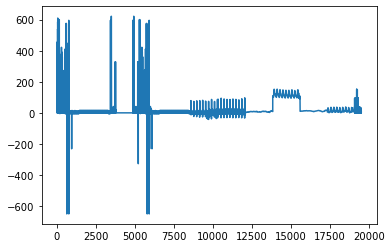

In [52]:
plt.plot(data)
plt.show()

In [47]:
data1

array([[  5.64,   5.48,   5.32, ...,   8.44,   8.4 ,   8.36],
       [109.68, 109.42, 109.14, ...,  94.22,  95.3 ,  96.38],
       [  9.92,   9.92,   9.9 , ...,  16.12,  16.1 ,  16.06],
       [  6.4 ,   6.04,   5.66, ...,  38.06,  37.92,  37.7 ]])

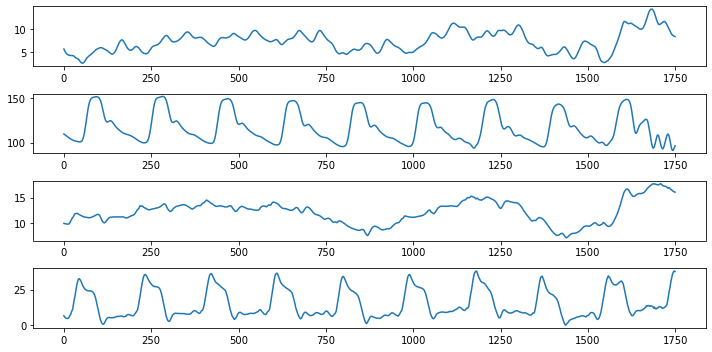

In [55]:
fig, axes = plt.subplots(len(data1), 1, figsize=(10, 5))
for i in range(0, len(data1)):
    axes[i].plot(data1[i])
    
plt.tight_layout()
plt.show()